# Objetivo do Trabalho
O objetivo deste trabalho é explorar a aplicação de técnicas de Machine Learning para identificar tendências de mercado em séries temporais financeiras altamente ruidosas, utilizando ações representativas do S&P 500. A abordagem trata os preços das ações como sinais financeiros compostos por uma componente de tendência estrutural e uma componente de ruído, refletindo a incerteza do mercado e o comportamento agregado dos participantes.


## O trabalho ambiciona:

- Demonstrar a viabilidade de extrair padrões estatísticos úteis em dados financeiros ruidosos, mesmo quando não é possível prever movimentos de preços pontuais.

- Treinar um modelo de Machine Learning que combine informações sobre tendência e ruído para estimar a probabilidade de movimentos direcionalmente positivos ou negativos do mercado.

- Aplicar o modelo a dados atuais para inferir tendências agregadas do mercado, apresentando uma visão interpretável (ex.: tendência de subida, descida ou neutra).

- Discutir os limites e implicações desta abordagem, incluindo a influência do ruído, volatilidade e regime de mercado, enfatizando que o objetivo não é gerar lucro ou previsão exata, mas sim uma prova de conceito académica robusta.

### Outros Objetivos

- Direção do Mercado (Classificação Binária/Multiclasse)
>Sobe ou Desce no próximo dia (classificação binária)
Alta, Baixa ou Lateral (classificação multiclasse)
Exemplo: "Amanhã a AAPL vai subir ou cair?"
>
- Volatilidade
>Prever se o próximo dia será volátil ou estável
>
- Faixas de Preço (Regressão por Intervalos)
>Prever em qual faixa o preço vai estar (ex: $220-225, $225-230)

## Recursos

Dataset
>  https://www.kaggle.com/datasets/tanavbajaj/yahoo-finance-all-stocks-dataset-daily-update
>
Como o dataset é atualizado a diáriamento a importação será feita via **link**
> https://www.kaggle.com/code/tanavbajaj/stock-dataset-scraper

# Expectativa de Resultados

## 1. Hipótese do Mercado Eficiente (EMH)

Segundo a teoria de **Eugene Fama**:

- **Mercados eficientes:** preços refletem **toda informação disponível**.
- **Limite teórico de acurácia:** ~50% (equivalente ao acaso puro).
- **Realidade:** Mercados são geralmente **semi-eficientes**.

---

## 2. Consenso Acadêmico e Profissional

| Horizonte       | Acurácia Realista | Acurácia "Excelente" | Observações |
|-----------------|-----------------|--------------------|------------|
| **Intraday (minutos)** | 52-55% | 58-62% | Alta frequência, muito ruído |
| **Diário (D+1)** | 52-56% | 58-65% | Padrões técnicos fracos |
| **Semanal (D+5)** | 55-60% | 65-70% | Tendências mais claras |
| **Mensal (D+20)** | 60-65% | 70-75% | Fundamentos dominam |

> Usando **apenas preços históricos (OHLCV)**, o **limite prático** de acurácia é **55-60%**.

### Limitações de Dados
- **Fundamentos:** balanços, lucros, guidance
- **Sentimento:** notícias, redes sociais, earnings calls
- **Orderflow:** fluxo de ordens, market microstructure
- **Macroeconômicos:** Fed, inflação, juros

---

## 3. Horizonte de Predição

- **Diário (D+1):** mais difícil, muito ruído  
- **Semanal (D+5):** +5-10% de acurácia potencial  
- **Mensal (D+20):** +10-15% de acurácia potencial  

---

## 4. Modelo de Decomposição de Sinais Financeiros

\[
\text{Preço}(t) = \text{Tendência}(t) + \text{Sentimento}(t) + \text{Ruído}(t)
\]

| Componente       | Descrição |
|-----------------|------------|
| **Tendência(t)** | Estrutura de longo prazo (previsível) |
| **Sentimento(t)** | Comportamento agregado dos participantes (semi-previsível) |
| **Ruído(t)**      | Aleatoriedade irredutível (imprevisível) |


In [79]:
!pip install -q yfinance

!pip install -q mlxtend
!pip install -q catboost
!pip install -q xgboost
!pip install -q lightgbm

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import warnings

# Pré-processamento
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Validação e métricas
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, 
                             classification_report, confusion_matrix, roc_auc_score)

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

**Variáveis Globais**

In [92]:
# Lista de ações do S&P 500 (empresas de tecnologia)
tech_list = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'NFLX']

end = datetime.now()
start = end - timedelta(days=3*365)
company_data = {}

In [128]:
# Baixar dados de forma correta
company_data = {}
for stock in tech_list:
    try:
        print(f"  Download {stock}...", end=" ")
        df = yf.download(stock, start=start, end=end, progress=False)
        if len(df) > 0:
            # IMPORTANTE: Achatar colunas se for MultiIndex
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            
            df = df.reset_index()  # Date vira coluna
            df['ticker'] = stock
            company_data[stock] = df
            print(f"{len(df)} dias")
        else:
            print("** Sem dados ! **")
    except Exception as e:
        print(f"Erro: {e}")

# Concatenar todos os dados
df_raw = pd.concat(company_data.values(), axis=0, ignore_index=True)

print(f"\nTotal de registros coletados: {len(df_raw)}")
print(f"    - Período: {df_raw['Date'].min().date()} até {df_raw['Date'].max().date()}")
print(f"    - Empresas: {df_raw['ticker'].nunique()}")
print("\nColunas:", df_raw.columns.tolist())
print("\nPrimeiras linhas:")
print(df_raw.head())

  Download AAPL... 752 dias
  Download MSFT... 752 dias
  Download GOOGL... 752 dias
  Download AMZN... 752 dias
  Download META... 752 dias
  Download NVDA... 752 dias
  Download TSLA... 752 dias
  Download NFLX... 752 dias

Total de registros coletados: 6016
    - Período: 2023-01-04 até 2026-01-02
    - Empresas: 8

Colunas: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'ticker']

Primeiras linhas:
Price       Date       Close        High         Low        Open    Volume  \
0     2023-01-04  124.482048  126.747869  123.221072  125.004170  89113600   
1     2023-01-05  123.161957  125.871086  122.905826  125.240599  80962700   
2     2023-01-06  127.693581  128.353621  123.033882  124.137239  87754700   
3     2023-01-09  128.215729  131.427289  127.959598  128.530980  70790800   
4     2023-01-10  128.787079  129.309201  126.215868  128.324063  63896200   

Price ticker  
0       AAPL  
1       AAPL  
2       AAPL  
3       AAPL  
4       AAPL  


### Decomposição: Tendência e Ruido

**Visualizações** 

In [130]:
def decompose_signal(series, window=20):
    """
    Decompõe o preço em tendência (média móvel) e ruído (desvio da tendência)
    Conceito: Preço = Tendência + Ruído
    """
    trend = series.rolling(window=window, center=False).mean()
    noise = series - trend
    return trend, noise

# Aplicar decomposição para cada ação (CORREÇÃO)
# Aplicar decomposição para cada ação
df_raw['Trend'] = df_raw.groupby('ticker')['Close'].transform(
    lambda x: x.rolling(window=20, center=False).mean()
)
df_raw['Noise'] = df_raw['Close'] - df_raw['Trend']

# Volatilidade
df_raw['Volatility'] = df_raw.groupby('ticker')['Close'].transform(
    lambda x: x.pct_change().rolling(20).std()
)

print("✓ Decomposição concluída")
print(df_raw[['Date', 'ticker', 'Close', 'Trend', 'Noise', 'Volatility']].head(25))


✓ Decomposição concluída
Price       Date ticker       Close       Trend      Noise  Volatility
0     2023-01-04   AAPL  124.482048         NaN        NaN         NaN
1     2023-01-05   AAPL  123.161957         NaN        NaN         NaN
2     2023-01-06   AAPL  127.693581         NaN        NaN         NaN
3     2023-01-09   AAPL  128.215729         NaN        NaN         NaN
4     2023-01-10   AAPL  128.787079         NaN        NaN         NaN
5     2023-01-11   AAPL  131.506073         NaN        NaN         NaN
6     2023-01-12   AAPL  131.427277         NaN        NaN         NaN
7     2023-01-13   AAPL  132.757172         NaN        NaN         NaN
8     2023-01-17   AAPL  133.919647         NaN        NaN         NaN
9     2023-01-18   AAPL  133.200500         NaN        NaN         NaN
10    2023-01-19   AAPL  133.259628         NaN        NaN         NaN
11    2023-01-20   AAPL  135.820969         NaN        NaN         NaN
12    2023-01-23   AAPL  139.012817         NaN     

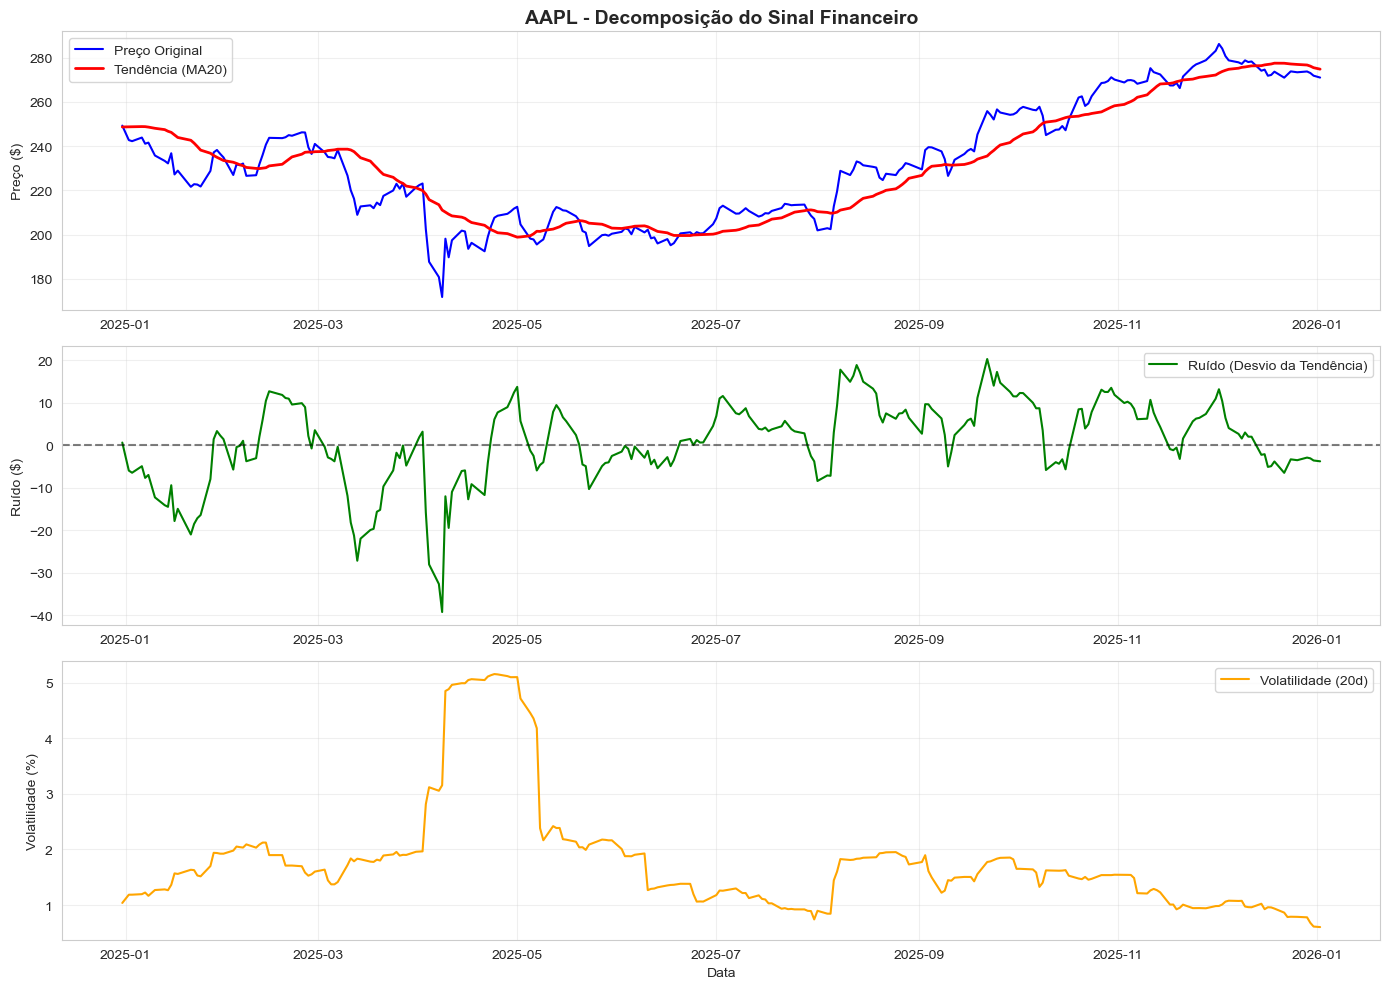

In [133]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
sample = df_raw[df_raw['ticker'] == 'AAPL'].iloc[-252:]  # Último ano

axes[0].plot(sample['Date'], sample['Close'], label='Preço Original', color='blue')
axes[0].plot(sample['Date'], sample['Trend'], label='Tendência (MA20)', color='red', linewidth=2)
axes[0].set_title('AAPL - Decomposição do Sinal Financeiro', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Preço ($)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(sample['Date'], sample['Noise'], label='Ruído (Desvio da Tendência)', color='green')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Ruído ($)')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(sample['Date'], sample['Volatility']*100, label='Volatilidade (20d)', color='orange')
axes[2].set_ylabel('Volatilidade (%)')
axes[2].set_xlabel('Data')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Feature Engeneering

In [135]:
def create_technical_indicators(df):
    """
    Cria indicadores técnicos que capturam tendência, momentum e volatilidade
    """
    df = df.copy()
    
    # Retornos
    df['Return_1d'] = df.groupby('ticker')['Close'].pct_change(1)
    df['Return_5d'] = df.groupby('ticker')['Close'].pct_change(5)
    df['Return_10d'] = df.groupby('ticker')['Close'].pct_change(10)
    
    # Médias Móveis (tendência de curto, médio e longo prazo)
    df['SMA_5'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(5).mean())
    df['SMA_10'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(10).mean())
    df['SMA_20'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(20).mean())
    df['SMA_50'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(50).mean())
    
    # Cruzamento de médias (sinal de mudança de tendência)
    df['SMA_Cross_5_20'] = (df['SMA_5'] - df['SMA_20']) / df['SMA_20']
    df['SMA_Cross_10_50'] = (df['SMA_10'] - df['SMA_50']) / df['SMA_50']
    
    # RSI (Relative Strength Index) - momentum
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df['RSI_14'] = df.groupby('ticker')['Close'].transform(lambda x: calculate_rsi(x, 14))
    
    # Bollinger Bands (volatilidade e extremos)
    df['BB_Middle'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(20).mean())
    df['BB_Std'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(20).std())
    df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * 2)
    df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * 2)
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # MACD (Moving Average Convergence Divergence)
    df['EMA_12'] = df.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=12).mean())
    df['EMA_26'] = df.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=26).mean())
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df.groupby('ticker')['MACD'].transform(lambda x: x.ewm(span=9).mean())
    df['MACD_Diff'] = df['MACD'] - df['MACD_Signal']
    
    # Volume (interesse do mercado)
    df['Volume_MA'] = df.groupby('ticker')['Volume'].transform(lambda x: x.rolling(20).mean())
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']
    
    # Volatilidade realizada
    df['Volatility_5d'] = df.groupby('ticker')['Return_1d'].transform(lambda x: x.rolling(5).std())
    df['Volatility_20d'] = df.groupby('ticker')['Return_1d'].transform(lambda x: x.rolling(20).std())
    
    # Range diário (High - Low)
    df['Daily_Range'] = (df['High'] - df['Low']) / df['Close']
    df['Daily_Range_MA'] = df.groupby('ticker')['Daily_Range'].transform(lambda x: x.rolling(10).mean())
    
    return df

df_features = create_technical_indicators(df_raw)

print(f"Features criadas: {df_features.shape[1]} colunas")

Features criadas: 36 colunas


### Criação de Targets

In [137]:
# TARGET 1: Direção Binária (Sobe/Desce)
df_features['Future_Return'] = df_features.groupby('ticker')['Close'].pct_change().shift(-1)
df_features['Target_Binary'] = (df_features['Future_Return'] > 0).astype(int)

# TARGET 2: Direção Multiclasse (Alta/Neutra/Baixa)
threshold = 0.005  # 0.5%
df_features['Target_Multiclass'] = pd.cut(
    df_features['Future_Return'],
    bins=[-np.inf, -threshold, threshold, np.inf],
    labels=[0, 1, 2]  # 0=Baixa, 1=Neutro, 2=Alta
).astype(float)

# TARGET 3: Volatilidade (Dia volátil ou estável)
vol_threshold = df_features['Future_Return'].abs().quantile(0.7)
df_features['Target_Volatility'] = (df_features['Future_Return'].abs() > vol_threshold).astype(int)

# TARGET 4: Faixa de Preço (Regressão por intervalos)
df_features['Future_Price'] = df_features.groupby('ticker')['Close'].shift(-1)
df_features['Price_Change_Pct'] = ((df_features['Future_Price'] - df_features['Close']) / df_features['Close']) * 100

# Criar bins de faixas de preço
df_features['Target_PriceRange'] = pd.cut(
    df_features['Price_Change_Pct'],
    bins=[-np.inf, -2, -1, 0, 1, 2, np.inf],
    labels=['<-2%', '-2 a -1%', '-1 a 0%', '0 a 1%', '1 a 2%', '>2%']
)

print("Targets criados:")
print(f"  - Target_Binary (Sobe/Desce): {df_features['Target_Binary'].value_counts().to_dict()}")
print(f"  - Target_Multiclass (Alta/Neutro/Baixa): {df_features['Target_Multiclass'].value_counts().to_dict()}")
print(f"  - Target_Volatility (Volátil/Estável): {df_features['Target_Volatility'].value_counts().to_dict()}")

✓ Targets criados:
  - Target_Binary (Sobe/Desce): {1: 3235, 0: 2781}
  - Target_Multiclass (Alta/Neutro/Baixa): {2.0: 2478, 0.0: 2055, 1.0: 1475}
  - Target_Volatility (Volátil/Estável): {0: 4213, 1: 1803}


### Preparação dos Dados

In [139]:
# Remover NaN
df_clean = df_features.dropna()

# Selecionar features para o modelo
feature_cols = [
    'Return_1d', 'Return_5d', 'Return_10d',
    'SMA_Cross_5_20', 'SMA_Cross_10_50',
    'RSI_14', 'BB_Position', 'MACD_Diff',
    'Volume_Ratio', 'Volatility_5d', 'Volatility_20d',
    'Daily_Range', 'Daily_Range_MA',
    'Trend', 'Noise', 'Volatility'  # Componentes de decomposição
]

X = df_clean[feature_cols]
y_binary = df_clean['Target_Binary']
y_multi = df_clean['Target_Multiclass']
y_vol = df_clean['Target_Volatility']

print(f"Dataset limpo: {len(X)} amostras")
print(f"   - Features: {len(feature_cols)}")
print(f"   - Período final: {df_clean['Date'].min().date()} até {df_clean['Date'].max().date()}")

Dataset limpo: 5616 amostras
   - Features: 16
   - Período final: 2023-03-16 até 2025-12-31


### Divisão Temporal dos Dados

Aplicamos parte teórica de séries temporaias


In [142]:
# Ordenar por data
df_clean = df_clean.sort_values('Date')

# Split temporal: 80% treino, 20% teste
split_date = df_clean['Date'].quantile(0.8)
train_mask = df_clean['Date'] <= split_date
test_mask = df_clean['Date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train_binary = y_binary[train_mask]
y_test_binary = y_binary[test_mask]
y_train_multi = y_multi[train_mask]
y_test_multi = y_multi[test_mask]
y_train_vol = y_vol[train_mask]
y_test_vol = y_vol[test_mask]

print(f"Treino: {len(X_train)} amostras ({df_clean[train_mask]['Date'].min().date()} até {df_clean[train_mask]['Date'].max().date()})")
print(f"Teste: {len(X_test)} amostras ({df_clean[test_mask]['Date'].min().date()} até {df_clean[test_mask]['Date'].max().date()})")

Treino: 4496 amostras (2023-03-16 até 2025-06-11)
Teste: 1120 amostras (2025-06-12 até 2025-12-31)


### Normalização 

In [144]:
# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Treino do Modelo

In [146]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

# Dicionário para armazenar resultados
results = {
    'Binary': {},
    'Multiclass': {},
    'Volatility': {}
}

In [148]:
# TAREFA 1: CLASSIFICAÇÃO BINÁRIA (SOBE/DESCE)
print("\nTAREFA 1: Classificação Binária (Sobe/Desce)")
print("-"*80)

for name, model in models.items():
    print(f"\nTreinando {name}...", end=" ")
    model.fit(X_train_scaled, y_train_binary)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_binary, y_pred)
    bal_acc = balanced_accuracy_score(y_test_binary, y_pred)
    f1 = f1_score(y_test_binary, y_pred)
    auc = roc_auc_score(y_test_binary, y_pred_proba)
    
    results['Binary'][name] = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'auc_roc': auc,
        'model': model
    }
    
    print(f"✓")
    print(f"  Acurácia: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

# TAREFA 2: CLASSIFICAÇÃO MULTICLASSE (ALTA/NEUTRO/BAIXA)
print("\n📊 TAREFA 2: Classificação Multiclasse (Alta/Neutro/Baixa)")
print("-"*80)

for name, model in models.items():
    print(f"\nTreinando {name}...", end=" ")
    model_multi = type(model)(**model.get_params())  # Clone
    model_multi.fit(X_train_scaled, y_train_multi)
    y_pred = model_multi.predict(X_test_scaled)
    
    acc = accuracy_score(y_test_multi, y_pred)
    bal_acc = balanced_accuracy_score(y_test_multi, y_pred)
    f1 = f1_score(y_test_multi, y_pred, average='weighted')
    
    results['Multiclass'][name] = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'model': model_multi
    }
    
    print(f"  Acurácia: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f}")

# TAREFA 3: PREVISÃO DE VOLATILIDADE
print("\nTAREFA 3: Previsão de Volatilidade (Volátil/Estável)")
print("-"*80)

for name, model in models.items():
    print(f"\nTreinando {name}...", end=" ")
    model_vol = type(model)(**model.get_params())  # Clone
    model_vol.fit(X_train_scaled, y_train_vol)
    y_pred = model_vol.predict(X_test_scaled)
    y_pred_proba = model_vol.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_vol, y_pred)
    bal_acc = balanced_accuracy_score(y_test_vol, y_pred)
    f1 = f1_score(y_test_vol, y_pred)
    auc = roc_auc_score(y_test_vol, y_pred_proba)
    
    results['Volatility'][name] = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'auc_roc': auc,
        'model': model_vol
    }

    print(f"  Acurácia: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


📊 TAREFA 1: Classificação Binária (Sobe/Desce)
--------------------------------------------------------------------------------

Treinando Logistic Regression... ✓
  Acurácia: 0.5357 | Balanced Acc: 0.5144 | F1: 0.6688 | AUC: 0.5141

Treinando Random Forest... ✓
  Acurácia: 0.5446 | Balanced Acc: 0.5319 | F1: 0.6368 | AUC: 0.5505

Treinando Gradient Boosting... ✓
  Acurácia: 0.5179 | Balanced Acc: 0.5068 | F1: 0.6058 | AUC: 0.5208

Treinando XGBoost... ✓
  Acurácia: 0.5446 | Balanced Acc: 0.5416 | F1: 0.5799 | AUC: 0.5453

Treinando LightGBM... ✓
  Acurácia: 0.5348 | Balanced Acc: 0.5309 | F1: 0.5768 | AUC: 0.5510

📊 TAREFA 2: Classificação Multiclasse (Alta/Neutro/Baixa)
--------------------------------------------------------------------------------

Treinando Logistic Regression... ✓
  Acurácia: 0.3982 | Balanced Acc: 0.3696 | F1: 0.3434

Treinando Random Forest... ✓
  Acurácia: 0.4027 | Balanced Acc: 0.3734 | F1: 0.3588

Treinando Gradient Boosting... ✓
  Acurácia: 0.4036 | Balanc

#### Analise de Resultados

In [162]:
# DataFrame de comparação
comparison_data = []
for task in ['Binary', 'Multiclass', 'Volatility']:
    for model_name, metrics in results[task].items():
        comparison_data.append({
            'Tarefa': task,
            'Modelo': model_name,
            'Acurácia': metrics['accuracy'],
            'Balanced Acc': metrics['balanced_accuracy'],
            'F1-Score': metrics['f1_score'],
            'AUC-ROC': metrics.get('auc_roc', np.nan)
        })

df_results = pd.DataFrame(comparison_data)

#### Visualização dos resultados


Tabela Comparativa de Métricas:
    Tarefa              Modelo  Acurácia  Balanced Acc  F1-Score  AUC-ROC
    Binary Logistic Regression  0.535714      0.514435  0.668790 0.514077
    Binary       Random Forest  0.544643      0.531890  0.636752 0.550452
    Binary   Gradient Boosting  0.517857      0.506757  0.605839 0.520813
    Binary             XGBoost  0.544643      0.541615  0.579901 0.545285
    Binary            LightGBM  0.534821      0.530892  0.576767 0.550964
Multiclass Logistic Regression  0.398214      0.369628  0.343417      NaN
Multiclass       Random Forest  0.402679      0.373367  0.358803      NaN
Multiclass   Gradient Boosting  0.403571      0.379030  0.374012      NaN
Multiclass             XGBoost  0.381250      0.368395  0.372942      NaN
Multiclass            LightGBM  0.375893      0.360592  0.363946      NaN
Volatility Logistic Regression  0.759821      0.530211  0.156740 0.663692
Volatility       Random Forest  0.760714      0.560741  0.263736 0.657063
Volat

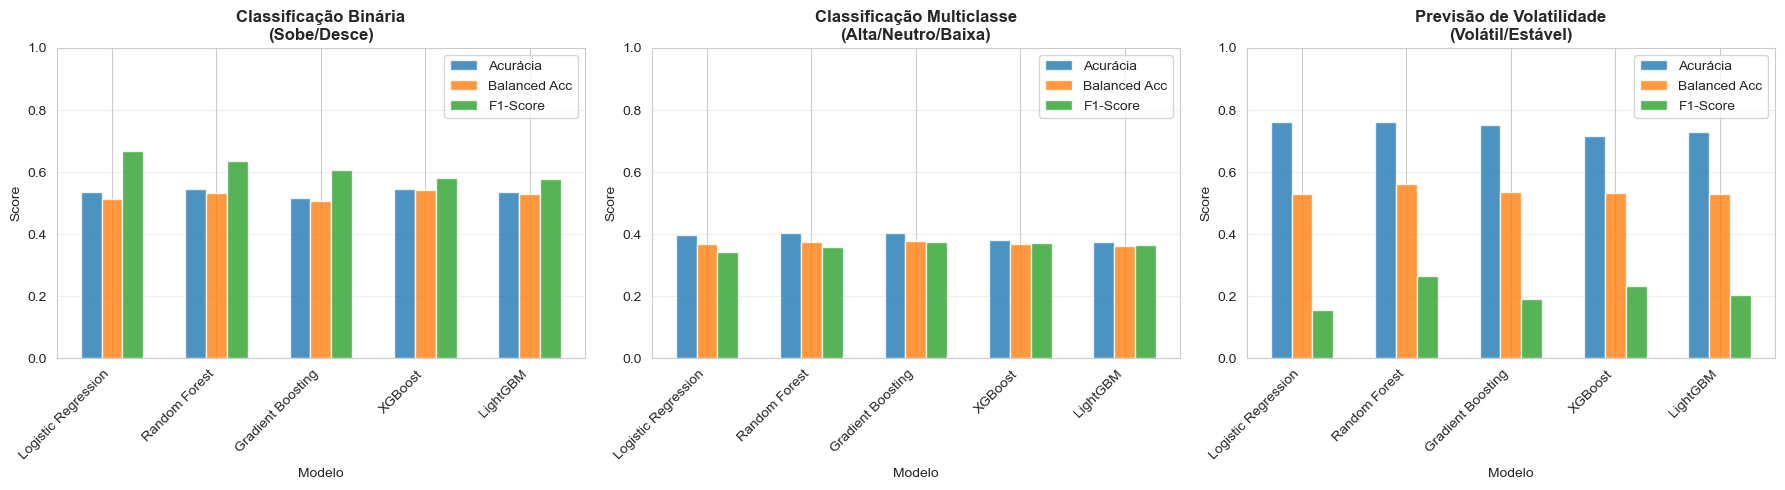

In [166]:
print("\nTabela Comparativa de Métricas:")
print(df_results.to_string(index=False))

# Visualização dos resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

tasks = ['Binary', 'Multiclass', 'Volatility']
titles = ['Classificação Binária\n(Sobe/Desce)', 
          'Classificação Multiclasse\n(Alta/Neutro/Baixa)', 
          'Previsão de Volatilidade\n(Volátil/Estável)']

for idx, (task, title) in enumerate(zip(tasks, titles)):
    data = df_results[df_results['Tarefa'] == task]
    
    x = np.arange(len(data))
    width = 0.2
    
    axes[idx].bar(x - width, data['Acurácia'], width, label='Acurácia', alpha=0.8)
    axes[idx].bar(x, data['Balanced Acc'], width, label='Balanced Acc', alpha=0.8)
    axes[idx].bar(x + width, data['F1-Score'], width, label='F1-Score', alpha=0.8)
    
    axes[idx].set_xlabel('Modelo')
    axes[idx].set_ylabel('Score')
    axes[idx].set_title(title, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(data['Modelo'], rotation=45, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()

### ANÁLISE DETALHADA DO MELHOR MODELO

ANÁLISE DETALHADA DO MELHOR MODELO

🏆 Melhor modelo: XGBoost
   Balanced Accuracy: 0.5416


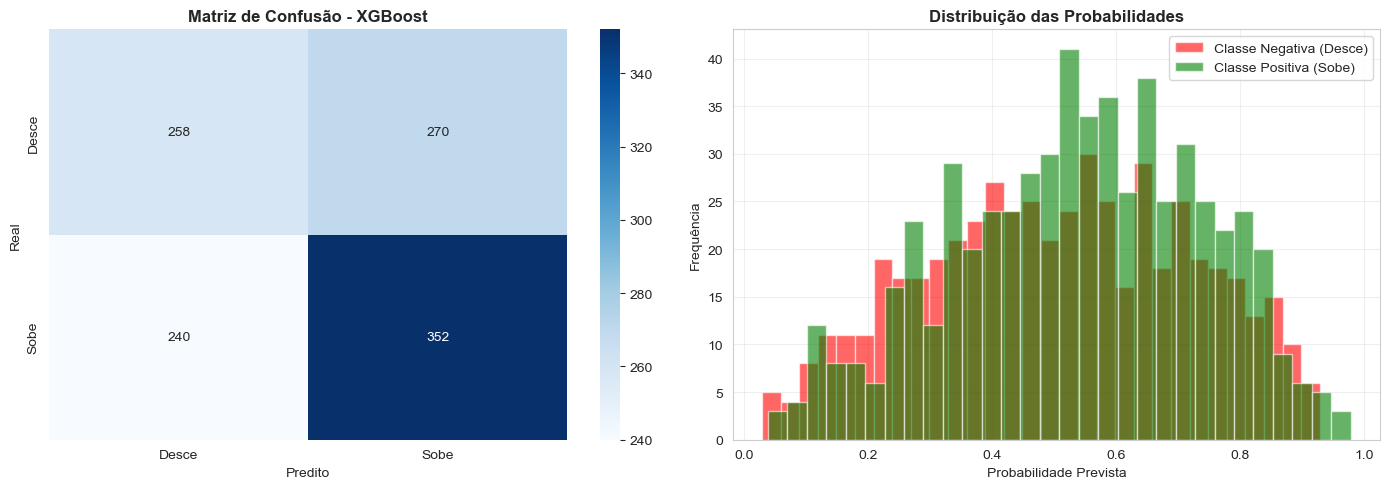

In [169]:
print("ANÁLISE DETALHADA DO MELHOR MODELO")

# Selecionar melhor modelo para classificação binária
best_model_name = max(results['Binary'], key=lambda x: results['Binary'][x]['balanced_accuracy'])
best_model = results['Binary'][best_model_name]['model']

print(f"\n🏆 Melhor modelo: {best_model_name}")
print(f"   Balanced Accuracy: {results['Binary'][best_model_name]['balanced_accuracy']:.4f}")

# Predições
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Matriz de confusão
cm = confusion_matrix(y_test_binary, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Matriz de Confusão - {best_model_name}', fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predito')
axes[0].set_xticklabels(['Desce', 'Sobe'])
axes[0].set_yticklabels(['Desce', 'Sobe'])

# Distribuição de probabilidades
axes[1].hist(y_pred_proba[y_test_binary == 0], bins=30, alpha=0.6, label='Classe Negativa (Desce)', color='red')
axes[1].hist(y_pred_proba[y_test_binary == 1], bins=30, alpha=0.6, label='Classe Positiva (Sobe)', color='green')
axes[1].set_xlabel('Probabilidade Prevista')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição das Probabilidades', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Relatório de Classificação:
              precision    recall  f1-score   support

       Desce       0.52      0.49      0.50       528
        Sobe       0.57      0.59      0.58       592

    accuracy                           0.54      1120
   macro avg       0.54      0.54      0.54      1120
weighted avg       0.54      0.54      0.54      1120


Top 10 Features Mais Importantes:
       Feature  Importance
SMA_Cross_5_20    0.071459
        RSI_14    0.071090
 Volatility_5d    0.070813
  Volume_Ratio    0.070731
   BB_Position    0.070221
         Noise    0.069503
     Return_1d    0.069117
    Return_10d    0.068690
         Trend    0.065475
     Return_5d    0.064164


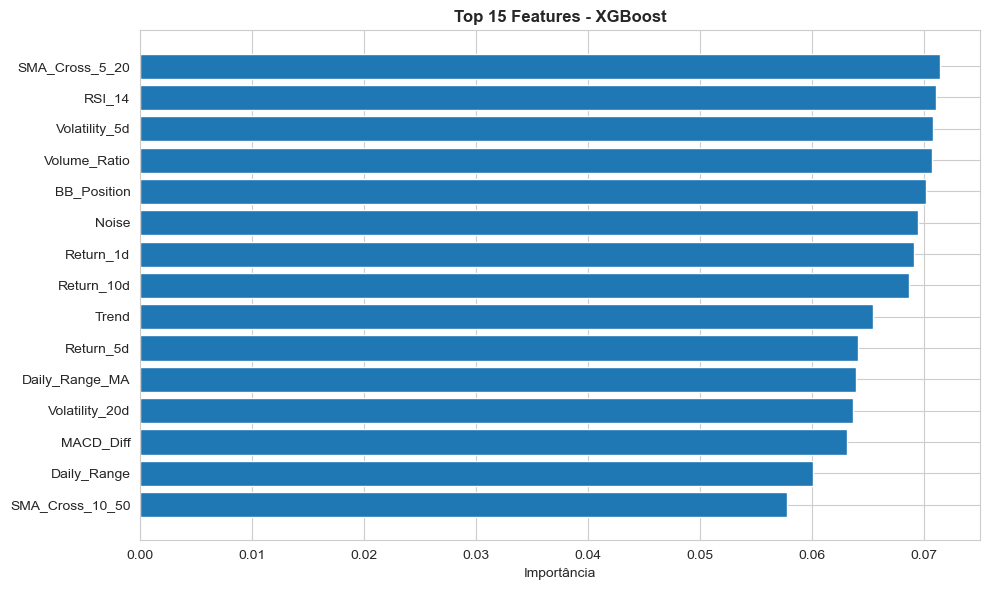

In [171]:
#### Overview da Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test_binary, y_pred, target_names=['Desce', 'Sobe']))

# Feature importance (se disponível)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Features Mais Importantes:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualizar
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'].head(15), feature_importance['Importance'].head(15))
    plt.xlabel('Importância')
    plt.title(f'Top 15 Features - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### INFERÊNCIA EM DADOS ATUAIS DO MERCADO

In [184]:
# Pegar últimos dados disponíveis
latest_data = df_clean.groupby('ticker').tail(1)
X_latest = latest_data[feature_cols]
X_latest_scaled = scaler.transform(X_latest)

# Predições
pred_binary = best_model.predict(X_latest_scaled)
pred_proba = best_model.predict_proba(X_latest_scaled)[:, 1]

# Criar DataFrame de resultados
inference_results = pd.DataFrame({
    'Ticker': latest_data['ticker'].values,
    'Data': latest_data['Date'].values,
    'Preço Atual': latest_data['Close'].values,
    'Previsão': ['SOBE ↑' if p == 1 else 'DESCE ↓' for p in pred_binary],
    'Confiança (%)': pred_proba * 100,
    'Sinal': ['FORTE' if (p > 0.6 or p < 0.4) else 'FRACO' for p in pred_proba]
})

print("Previsões para o Próximo Dia:")
print("\n")
print(inference_results.to_string(index=False))

# Tendência agregada do mercado
market_sentiment = pred_binary.mean()
print(f"\nTENDÊNCIA AGREGADA DO MERCADO:")
if market_sentiment > 0.6:
    print(f"    ALTA ({market_sentiment*100:.1f}% das ações com tendência de subida)")
elif market_sentiment < 0.4:
    print(f"    BAIXA ({(1-market_sentiment)*100:.1f}% das ações com tendência de queda)")
else:
    print(f"    NEUTRA ({market_sentiment*100:.1f}% de equilíbrio)")

Previsões para o Próximo Dia:


Ticker       Data  Preço Atual Previsão  Confiança (%) Sinal
  AMZN 2025-12-31   230.820007   SOBE ↑      69.041916 FORTE
  NVDA 2025-12-31   186.500000  DESCE ↓      43.132629 FRACO
  META 2025-12-31   660.090027  DESCE ↓      31.975094 FORTE
 GOOGL 2025-12-31   313.000000   SOBE ↑      65.459236 FORTE
  MSFT 2025-12-31   483.619995  DESCE ↓      35.914085 FORTE
  AAPL 2025-12-31   271.859985   SOBE ↑      70.893829 FORTE
  TSLA 2025-12-31   449.720001  DESCE ↓      49.071110 FRACO
  NFLX 2025-12-31    93.760002   SOBE ↑      61.042088 FORTE

TENDÊNCIA AGREGADA DO MERCADO:
    NEUTRA (50.0% de equilíbrio)
